In [1]:
import pandas as pd

file_path = "/content/fer2013.csv"
df = pd.read_csv(file_path)

print("Dataste Loaded First 5 Rows:")
print(df.head())

print("\nDatset Information:")
print(df.info())

Dataste Loaded First 5 Rows:
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

Datset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None


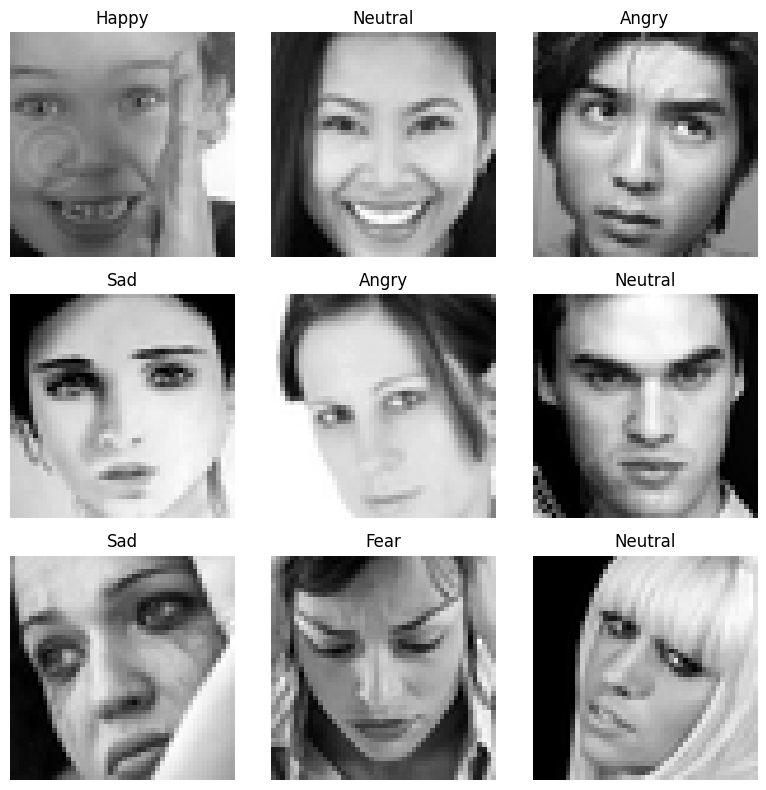

In [2]:
import numpy as np
import matplotlib.pyplot as plt

emotion_dict = {
    0: "Angry", 1: "Disgust", 2: "Fear",
    3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"
}

def process_image(pixel_string):
    try:
        pixels = np.array([int(p) for p in pixel_string.split()], dtype = np.uint8)
        if len(pixels) != 2304:
            return None
        return pixels.reshape(48, 48)
    except:
        return None

df["image"] = df["pixels"].apply(process_image)
df = df.dropna(subset = ["image"]).reset_index(drop = True)

fig, axes = plt.subplots(3, 3, figsize = (8,8))
sample_images = df.sample(9, random_state = 42)

for i, (idx, row) in enumerate(sample_images.iterrows()):
    img = row["image"]
    ax = axes[i // 3, i % 3]
    ax.imshow(img, cmap = "gray")
    ax.set_title(emotion_dict[row["emotion"]])
    ax.axis("off")

plt.tight_layout()
plt.show()

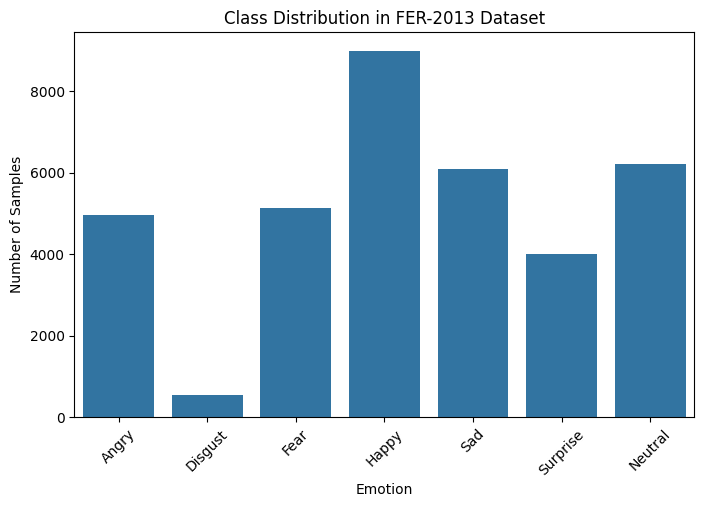

In [3]:
import seaborn as sns

emotion_count = df["emotion"].value_counts().sort_index()

plt.figure(figsize = (8,5))
sns.barplot(x =[emotion_dict[i] for i in emotion_count.index], y = emotion_count.values)
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in FER-2013 Dataset")
plt.xticks(rotation = 45)
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df["image"] = df["image"].apply(lambda x: x / 255.0)

X_original = np.stack(df["image"].values).reshape(-1, 48, 48, 1)
y_original = np.array(df["emotion"].values)

data_gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    brightness_range = [0.8, 1.2]
)

augmented_images = []
augmented_labels = []

for emotion in [1, 5]:
    subset = df[df["emotion"] == emotion]
    images = np.stack(subset["image"].values).reshape(-1, 48, 48, 1)
    labels = np.array([emotion] * len(images))

    for img, label in zip(images, labels):
        img = img.reshape((1, 48, 48, 1))
        augmented = data_gen.flow(img, batch_size = 1)
        for _ in range(3):
            aug_img = next(augmented)[0]
            augmented_images.append(aug_img)
            augmented_labels.append(label)

augmented_images= np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

X_original = X_original.reshape(-1, 48, 48, 1)
X_train = np.concatenate((X_original, augmented_images), axis = 0)
y_train = np.concatenate((y_original, augmented_labels), axis = 0)

print("Data Augmentation applied successfully")
print("New Dataset shape:", X_train.shape, "with", y_train.shape[0], "labels.")

Data Augmentation applied successfully
New Dataset shape: (49534, 48, 48, 1) with 49534 labels.


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_regularizer = l2(1e-4), input_shape = (48, 48, 1)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_regularizer = l2(1e-4)),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_regularizer = l2(1e-4)),
    BatchNormalization(),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_regularizer = l2(1e-4)),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_regularizer = l2(1e-4)),
    BatchNormalization(),
    Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_regularizer = l2(1e-4)),
    MaxPooling2D(pool_size = (2,2)),

    Flatten(),
    Dense(512, activation = 'relu', kernel_regularizer = l2(1e-4)),
    Dropout(0.4),
    Dense(128, activation= 'relu', kernel_regularizer = l2(1e-4)),
    Dropout(0.3),
    Dense(7, activation = 'softmax')

])

model.summary()
print("CNN Model Build Successfully")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,931,719 (22.63 MB)

 Trainable params: 5,930,823 (22.62 MB)

 Non-trainable params: 896 (3.50 KB)

CNN Model Build Successfully


In [6]:
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(learning_rate = 3e-4, weight_decay= 1e-5)

model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1),
    optimizer = optimizer,
    metrics = ["accuracy"]
)

print("Model Compile Successfully")

Model Compile Successfully


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
lr_scheduler = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, min_lr = 1e-6, verbose= 1)

print("callbaclks define successfully")

callbaclks define successfully


In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X_train, y_train, test_size = 0.5, random_state = 42)
y_train_70_categorical= to_categorical(y_train_70, num_classes = 7)
y_test_30_categorical= to_categorical(y_test_30, num_classes = 7)

print("Using 70% of Data:", X_train_70.shape, y_train_70_categorical.shape)

Using 70% of Data: (24767, 48, 48, 1) (24767, 7)


In [9]:
history_finetune = model.fit(
    X_train_70, y_train_70_categorical,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 64,
    callbacks= [early_stopping, lr_scheduler],
    verbose = 1
)

print("Training on 70% of Dataset Completed")

Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1211s 4s/step - accuracy: 0.3729 - loss: 2.0022 - val_accuracy: 0.1815 - val_loss: 2.2086 - learning_rate: 3.0000e-04
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1222s 4s/step - accuracy: 0.4371 - loss: 1.7187 - val_accuracy: 0.4911 - val_loss: 1.6646 - learning_rate: 3.0000e-04
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1199s 4s/step - accuracy: 0.4787 - loss: 1.6236 - val_accuracy: 0.5157 - val_loss: 1.5885 - learning_rate: 3.0000e-04
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1204s 4s/step - accuracy: 0.5035 - loss: 1.5688 - val_accuracy: 0.5313 - val_loss: 1.5909 - learning_rate: 3.0000e-04
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1203s 4s/step - accuracy: 0.5291 - loss: 1.5142 - val_accuracy: 0.5408 - val_loss: 1.5521 - learning_rate: 3.0000e-04
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1202s 4s/step - accuracy: 0.5598 - loss: 1.4536 - val_accuracy: 0.5965 - val_loss: 1.4611 - learning_rate: 3.0000e-04
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1217s 4s/ste

In [11]:
test_loss, test_accuracy = model.evaluate(X_train_70, y_train_70_categorical)
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

774/774 ━━━━━━━━━━━━━━━━━━━━ 360s 464ms/step - accuracy: 0.7157 - loss: 1.2504
Final Test Accuracy: 70.23%
Final Test Loss: 1.2680


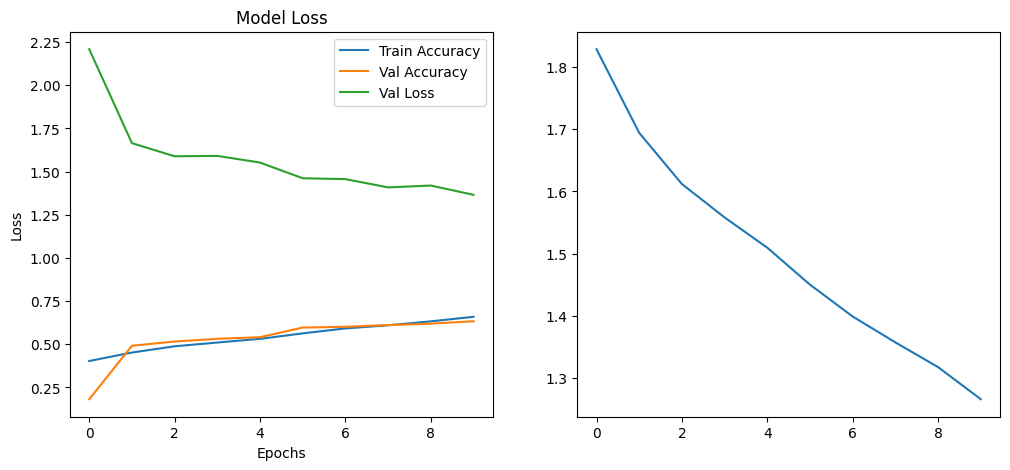

In [12]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

    ax1.plot(history.history['accuracy'], label = 'Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label = 'Val Accuracy')
    ax1.set_title('Model Accuarcy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label = 'Train Loss')
    ax1.plot(history.history['val_loss'], label = 'Val Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    plt.show()
plot_training_history(history_finetune)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


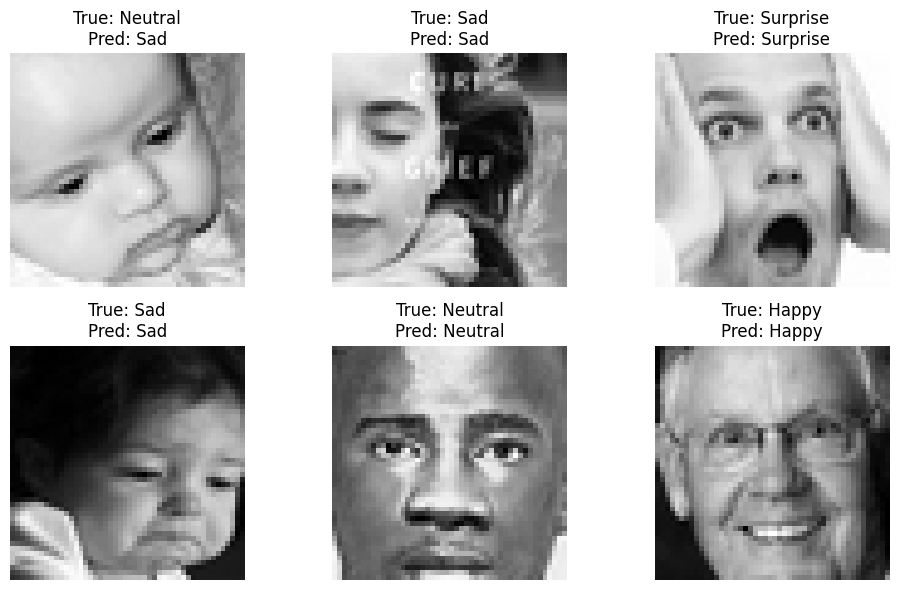

In [20]:
num_samples = 6
sample_indices = np.random.choice(len(X_train_70), num_samples, replace = False)
sample_images = X_train_70[sample_indices]
true_labels = np.argmax(y_train_70_categorical[sample_indices], axis = 1)

predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis = 1)

fig, axes = plt.subplots(2,3, figsize = (10, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i].squeeze(), cmap = 'gray')
    ax.set_title(f"True: {emotion_dict[true_labels[i]]}\nPred: {emotion_dict[predicted_labels[i]]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

774/774 ━━━━━━━━━━━━━━━━━━━━ 346s 447ms/step


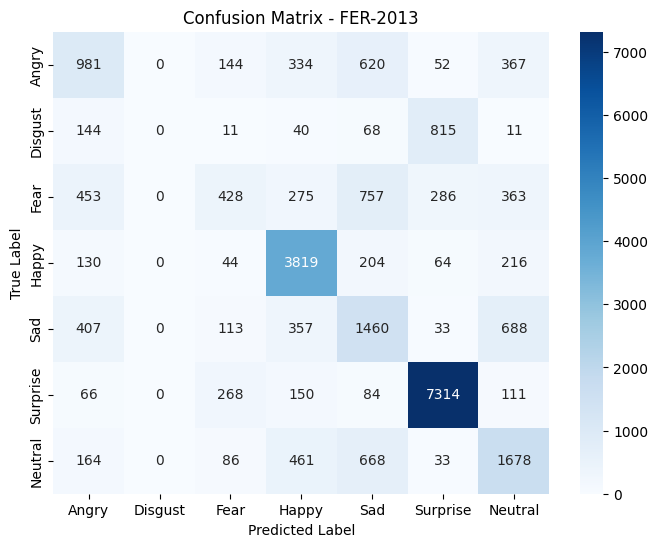

In [22]:
from sklearn.metrics import confusion_matrix

true_labels =  np.argmax(y_test_30_categorical, axis = 1)
predicted_labels = np.argmax(model.predict(X_test_30), axis = 1)

cm = confusion_matrix(true_labels, predicted_labels)
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = emotion_labels, yticklabels = emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - FER-2013")
plt.show()

In [23]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"])
print("Classification Report")
print(report)

Classification Report
              precision    recall  f1-score   support

       Angry       0.42      0.39      0.41      2498
     Disgust       0.00      0.00      0.00      1089
        Fear       0.39      0.17      0.23      2562
       Happy       0.70      0.85      0.77      4477
         Sad       0.38      0.48      0.42      3058
    Surprise       0.85      0.92      0.88      7993
     Neutral       0.49      0.54      0.51      3090

    accuracy                           0.63     24767
   macro avg       0.46      0.48      0.46     24767
weighted avg       0.59      0.63      0.61     24767



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
